In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical

E0000 00:00:1731089576.973686      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1108 18:12:56.982171828      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1108 18:12:56.982189086      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1108 18:12:56.982192409      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1108 18:12:56.982194856      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1108 18:12:56.982197298      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("No TPU found. Using default strategy.")
    strategy = tf.distribute.get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1731089587.620494      13 service.cc:145] XLA service 0x5ba784c75b70 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731089587.620550      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1731089587.620554      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1731089587.620557      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1731089587.620560      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1731089587.620563      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1731089587.620566      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1731089587.620568      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1731089587.620573      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [3]:
import os

paths = []
labels = []

# Define the root directory
real_root_dir = '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs'
fake_root_dir = '/kaggle/input/wavefake-test/generated_audio/ljspeech_melgan'
# Iterate through the subdirectories
for filename in os.listdir(real_root_dir):
    file_path = os.path.join(real_root_dir, filename)
    paths.append(file_path)
    # Add label based on the subdirectory name
    labels.append('real')
    
for filename in os.listdir(fake_root_dir):
    file_path = os.path.join(fake_root_dir, filename)
    paths.append(file_path)
    # Add label based on the subdirectory name
    labels.append('fake')

print('Dataset is loaded')


Dataset is loaded


In [4]:
print(len(paths))

26200


In [5]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels


In [6]:
len(labels)

26200

In [7]:
df['label'].value_counts()

label
real    13100
fake    13100
Name: count, dtype: int64

**Visualization of Audio and Features**

In [8]:
real_audio = '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ001-0001.wav'
fake_audio = '/kaggle/input/wavefake-test/generated_audio/ljspeech_melgan/LJ001-0001_gen.wav'

In [9]:
print('Real Audio:')
IPython.display.Audio(real_audio)

Real Audio:


In [10]:
print('Fake Audio:')
IPython.display.Audio(fake_audio)

Fake Audio:


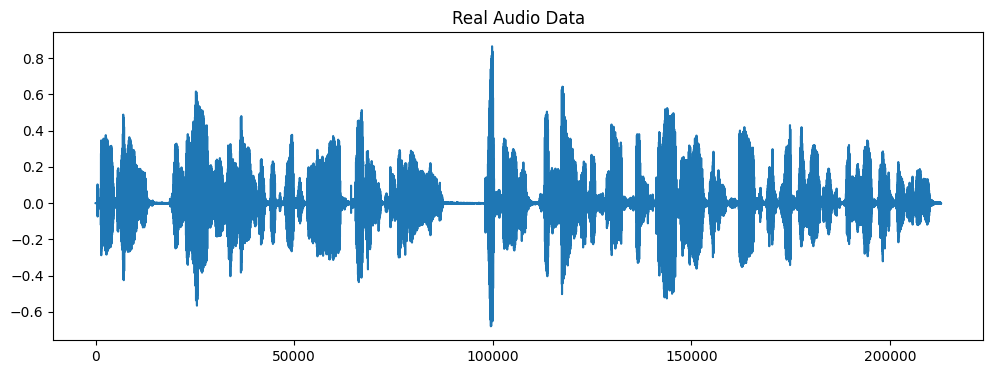

In [11]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize= (12,4))
plt.plot(real_ad)
plt.title('Real Audio Data')
plt.show()

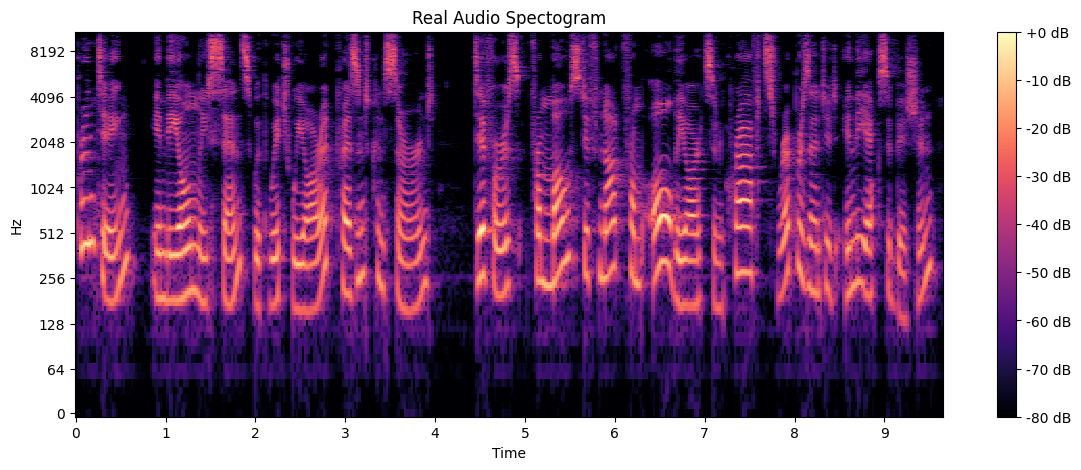

In [12]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(real_spec, sr = real_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Audio Spectogram")
plt.show()

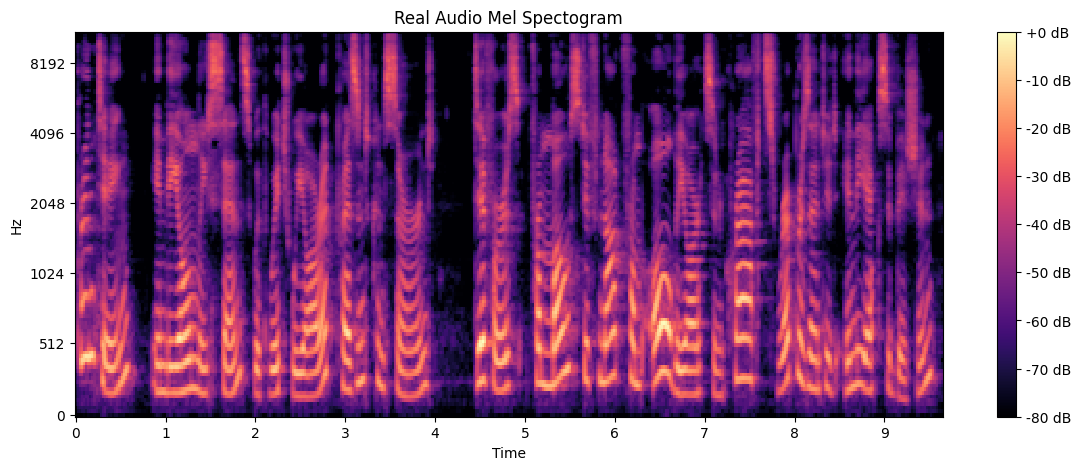

In [13]:
real_mel_spect = librosa.feature.melspectrogram(y = real_ad, sr = real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Real Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()

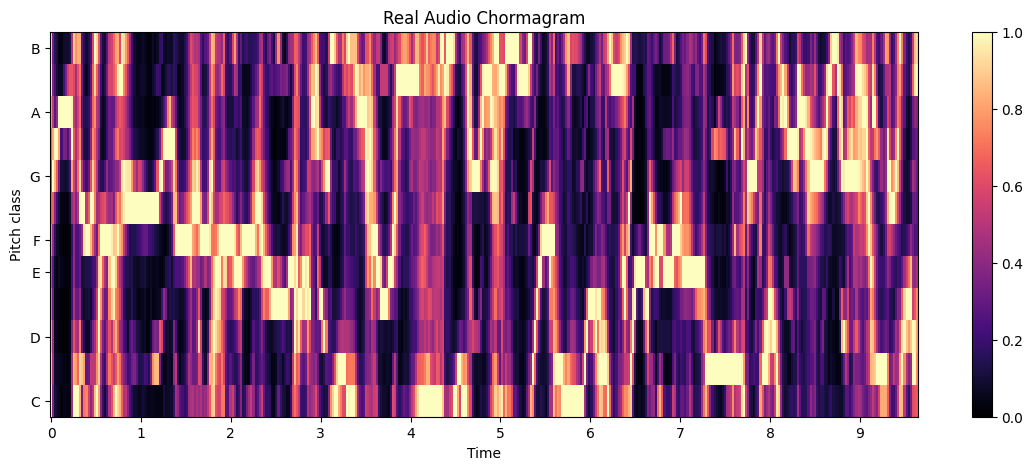

In [14]:
real_chroma = librosa.feature.chroma_cqt(y = real_ad, sr = real_sr, bins_per_octave=36)
plt.figure(figsize = (14, 5))
librosa.display.specshow(real_chroma, sr = real_sr, x_axis = 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Real Audio Chormagram')
plt.show()

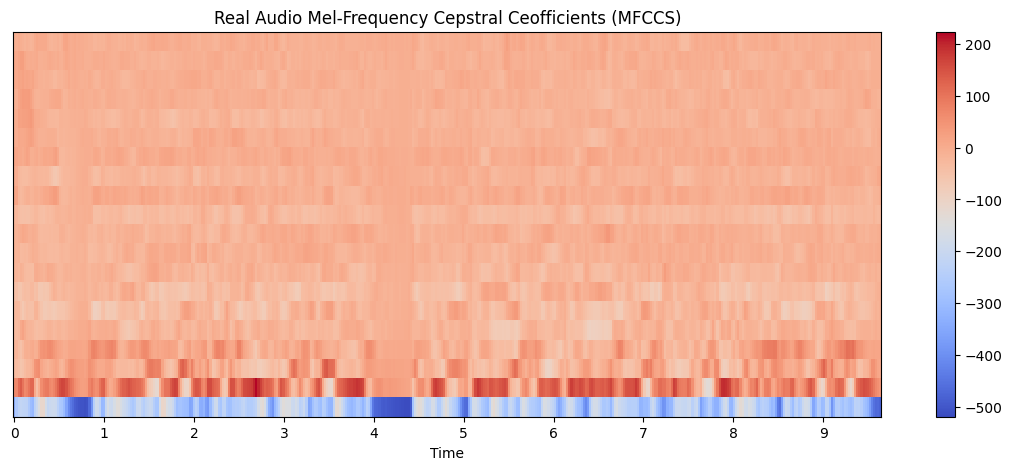

In [15]:
real_mfcc = librosa.feature.mfcc(y = real_ad, sr = real_sr)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mfcc, sr = real_sr, x_axis ='time')
plt.colorbar()
plt.title('Real Audio Mel-Frequency Cepstral Ceofficients (MFCCS)')
plt.show()

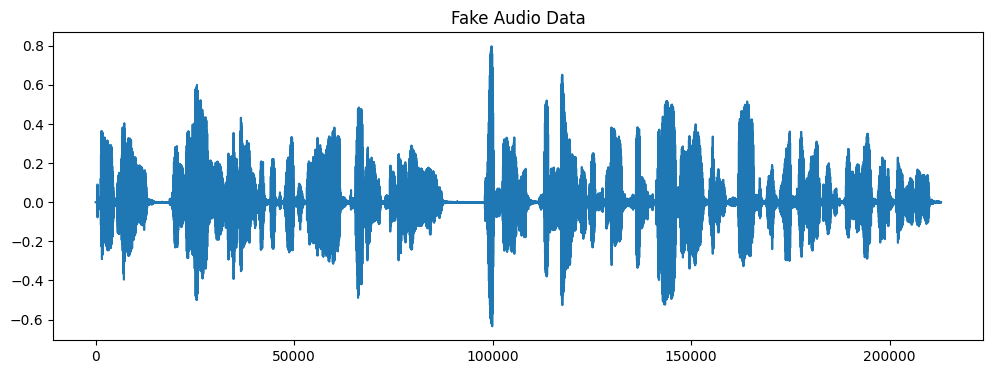

In [16]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize =(12,4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

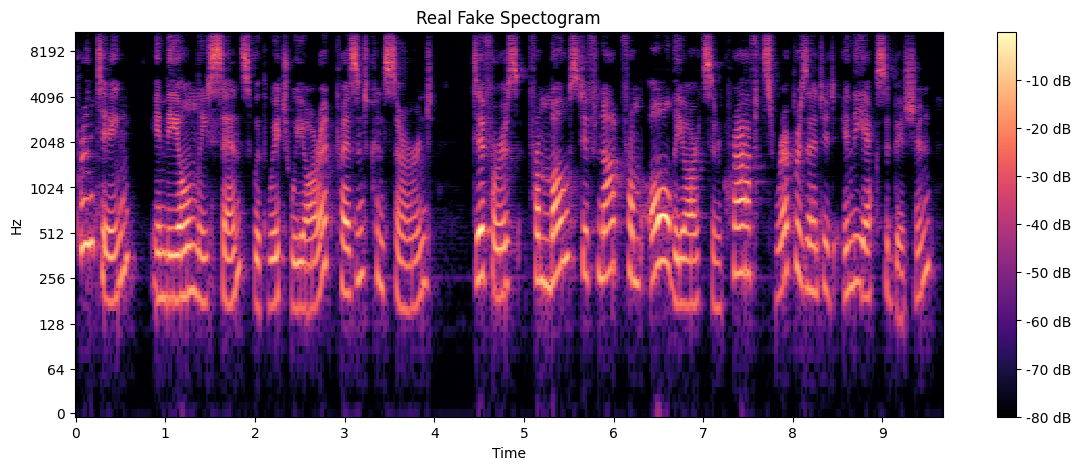

In [17]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_spec, sr = fake_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Fake Spectogram")
plt.show()

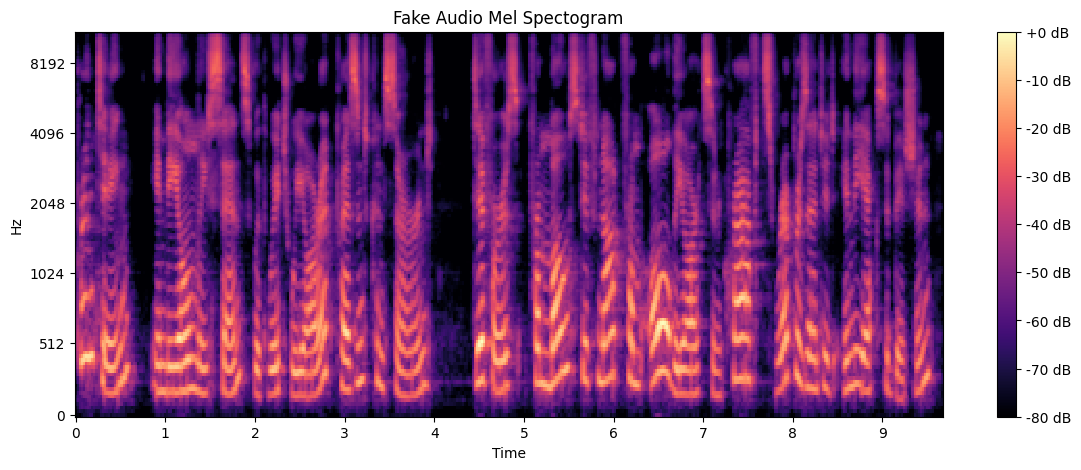

In [18]:
fake_mel_spect = librosa.feature.melspectrogram(y = fake_ad, sr = fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Fake Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()


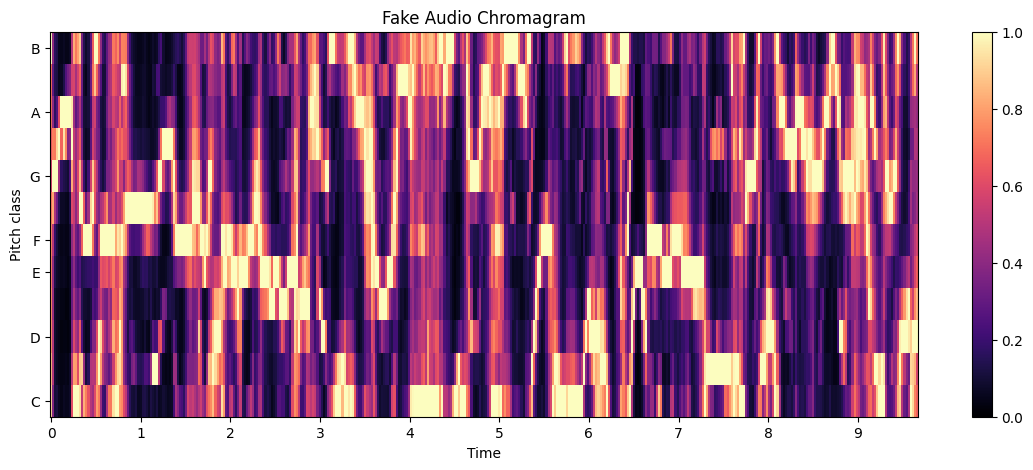

In [19]:
fake_chroma = librosa.feature.chroma_cqt(y = fake_ad, sr = fake_sr, bins_per_octave=36)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_chroma, sr = fake_sr, x_axis= 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Fake Audio Chromagram')
plt.show()

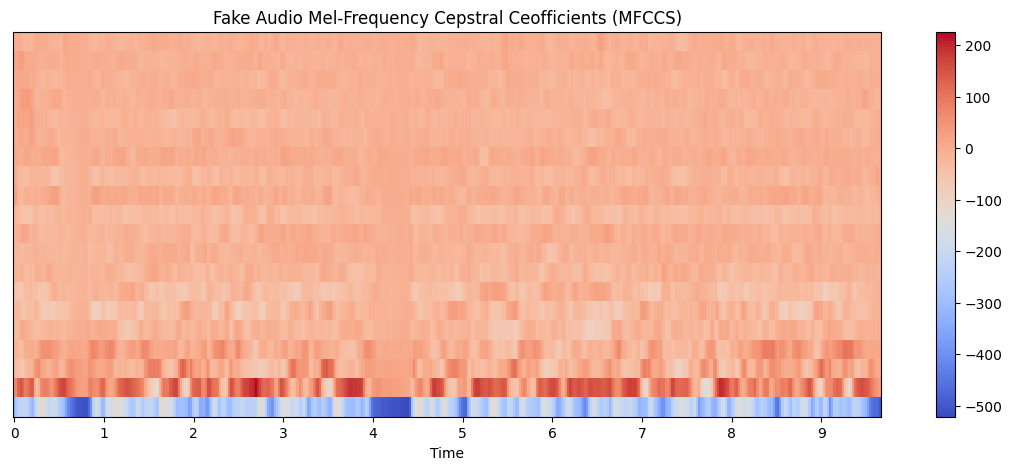

In [20]:
fake_mfcc = librosa.feature.mfcc(y = fake_ad, sr = fake_sr)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mfcc, sr = fake_sr, x_axis ='time')
plt.colorbar()
plt.title('Fake Audio Mel-Frequency Cepstral Ceofficients (MFCCS)')
plt.show()

In [21]:
def extract_features(fake_root_dir, real_root_dir, max_length=500):
    features = []
    labels = []
    
    for file in os.listdir(fake_root_dir):
        file_path = os.path.join(fake_root_dir, file)
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            # Extract features (example: using Mel-Frequency Cepstral Coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
            # Pad or trim the feature array to a fixed length
            if mfccs.shape[1] < max_length:
                mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]
            features.append(mfccs)
            # Assign label
            labels.append(1)  # 1 for fake
            
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue
            
    for file in os.listdir(real_root_dir):
        file_path = os.path.join(real_root_dir, file)
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            # Extract features (example: using Mel-Frequency Cepstral Coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
            # Pad or trim the feature array to a fixed length
            if mfccs.shape[1] < max_length:
                mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]
            features.append(mfccs)
            # Assign label
            labels.append(0)  # 0 for real
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue
    return np.array(features), np.array(labels)

# Example usage

x, y = extract_features(fake_root_dir, real_root_dir)

print("Features shape:", x.shape)
print("Labels shape:", y.shape)

Features shape: (26200, 40, 500)
Labels shape: (26200,)


In [22]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = .2)

**Model Architecture**

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers
with strategy.scope():
    # Create and compile the model inside the strategy scope
    model = Sequential([
        layers.Reshape((40, 500, 1), input_shape=xtrain.shape[1:]),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Reshape((-1, 128)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        layers.BatchNormalization(),
        layers.Bidirectional(layers.LSTM(128, dropout=0.3, recurrent_dropout=0.2)),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    

# Print the model summary to confirm the structure
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 40, 500, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 500, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 40, 500, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 250, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 250, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 250, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 125, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 125, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 125, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 62, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 310, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 310, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 310, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,049 (3.00 MB)

 Trainable params: 784,577 (2.99 MB)

 Non-trainable params: 1,472 (5.75 KB)

***Training***

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback to monitor validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',        # Monitor validation accuracy instead of loss
    patience=10,                     # Stop after 10 epochs of no improvement
    restore_best_weights=True,      # Restore the weights from the epoch with the best validation accuracy
    mode='max',                     # 'max' because higher accuracy is better (we want to maximize val_accuracy)
    verbose=1                       # Output when training stops early
)

# Train the model with early stopping
history = model.fit(
    xtrain, ytrain,                 # Training data
    epochs=100,                      # Max number of epochs
    batch_size=32,                  # Batch size
    validation_data=(xtest, ytest),   # Validation data
    callbacks=[early_stopping]      # Add early stopping callback
)

Epoch 1/100


2024-11-08 18:50:27.445262: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1731091827.882690     808 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8c469ac960c8fc18:0:0), session_name()


  1/655 ━━━━━━━━━━━━━━━━━━━━ 3:39:51 20s/step - accuracy: 0.7500 - loss: 0.7757

I0000 00:00:1731091844.228623     808 tpu_compile_op_common.cc:245] Compilation of 8c469ac960c8fc18:0:0 with session name  took 16.345883377s and succeeded
I0000 00:00:1731091844.299302     808 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8c469ac960c8fc18:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17644147200270265165", property.function_library_fingerprint = 1687587056866424243, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731091844.299348     808 tpu_compilation_cache_interface.cc:541] After adding entry for key 8c469ac960c8fc18:0

655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5057 - loss: 0.9837

I0000 00:00:1731091876.720018     780 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c3723e458845f82c:0:0), session_name()
I0000 00:00:1731091879.555028     780 tpu_compile_op_common.cc:245] Compilation of c3723e458845f82c:0:0 with session name  took 2.834954291s and succeeded
I0000 00:00:1731091879.563741     780 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c3723e458845f82c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9277510854267869247", property.function_library_fingerprint = 13144800264853156698, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,40,500,;4,;", property.guaranteed_constants_size = 0, embedding_

655/655 ━━━━━━━━━━━━━━━━━━━━ 62s 63ms/step - accuracy: 0.5057 - loss: 0.9836 - val_accuracy: 0.4916 - val_loss: 0.8090
Epoch 2/100


I0000 00:00:1731091885.545276     806 tpu_compile_op_common.cc:245] Compilation of f38eed2fe5ba443:0:0 with session name  took 2.620925135s and succeeded
I0000 00:00:1731091885.551432     806 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f38eed2fe5ba443:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9277510854267869247", property.function_library_fingerprint = 13144800264853156698, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,40,500,;3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731091885.551467     806 tpu_compilation_cache_interface.cc:541] After adding entry for key f38eed2f

655/655 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.4898 - loss: 0.8209 - val_accuracy: 0.5069 - val_loss: 0.7684
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.5023 - loss: 0.7607 - val_accuracy: 0.5084 - val_loss: 0.7442
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.5498 - loss: 0.7203 - val_accuracy: 0.4992 - val_loss: 0.7696
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.6172 - loss: 0.6715 - val_accuracy: 0.5099 - val_loss: 1.6287
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.7230 - loss: 0.5676 - val_accuracy: 0.8641 - val_loss: 0.3715
Epoch 7/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.8434 - loss: 0.4149 - val_accuracy: 0.5313 - val_loss: 0.9099
Epoch 8/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.8679 - loss: 0.3374 - val_accuracy: 0.8412 - val_loss: 0.3035
Epoch 9/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.8819 - loss: 0.3064 - val_

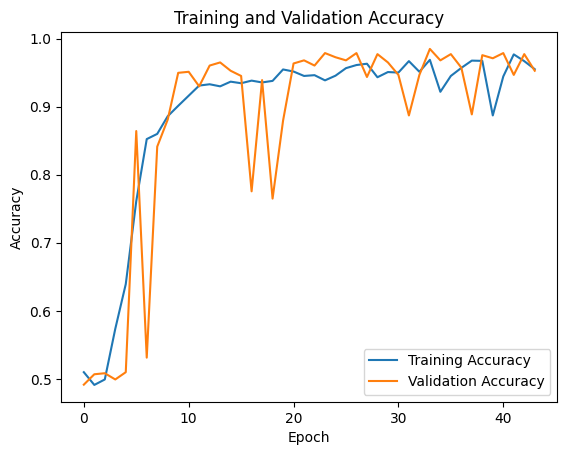

In [32]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [27]:
loss,accuracy = model.evaluate(xtest,ytest)

164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9718 - loss: 0.1018


In [54]:
# Create a CPU model with the same architecture
cpu_model = tf.keras.models.clone_model(model)

# Copy weights from TPU model to CPU model
cpu_model.set_weights(model.weights)

# Save the CPU model
cpu_model.save('my_model.h5')

In [55]:
/kaggle/working

NameError: name 'kaggle' is not defined